In [ ]:
"""
Author: Sikder Tahsin Al Amin
Description: Predict sales prices and practice feature engineering, RFs, and gradient boosting
"""

In [205]:
import numpy as np
import pandas as pd

df = pd.read_csv("/house_prices/train.csv") #train set
df_test = pd.read_csv("/house_prices/test.csv") #test set

print(df.head(5))
print(df_test.head(5))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

# Exploratory Analysis 

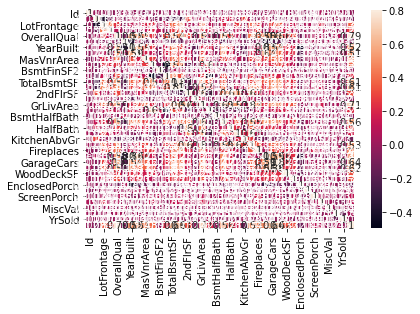

In [159]:
import seaborn as sn
import matplotlib.pyplot as plt

#correaltion matrix
numeric_features = df.select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr()
sn.heatmap(corr_matrix, vmax=.8, annot=True)
plt.show()

Skew is: 1.8828757597682129


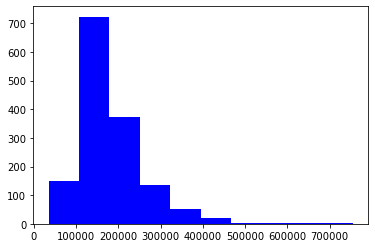

In [160]:
#Explore output column; histogram 
print ("Skew is:", df.SalePrice.skew())
plt.hist(df.SalePrice, color='blue')
plt.show()

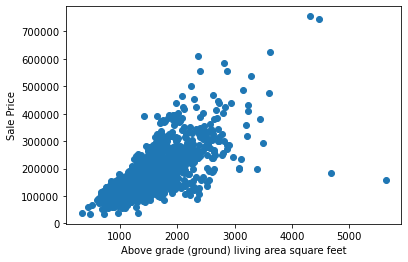

In [161]:
#visualize the relationship between the Ground Living Area GrLivArea and SalePrice.
plt.scatter(x=df['GrLivArea'], y=df['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area square feet')
plt.show()
#alternative way
#df.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000)) 

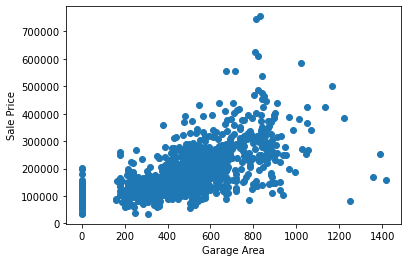

In [162]:
# visualize the relationship between the Garage Area GarageArea and SalePrice.
plt.scatter(x=df['GarageArea'], y=df['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

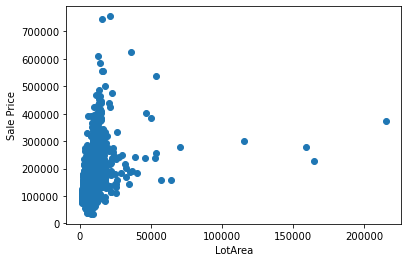

In [207]:
# visualize the relationship between the Lot Area and SalePrice.
plt.scatter(x=df['LotArea'], y=df['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('LotArea')
plt.show()

# Feature Engineering

In [208]:
# Remove outliers from GarageArea, LotArea
df = df[df['GarageArea'] <= 1200]
df = df[df['LotArea'] <= 150000]

In [209]:
# Handling Null values 
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

print("shape = ", df.shape)
columns = df.columns #get the columns name
for i in columns:
    tmp = df[i].isnull().values.any()
    if tmp:
        print(i, df[i].isnull().sum(), df[i].dtype)
        if is_numeric_dtype(df[i]): #not necessary, all data types are object
            df[i].fillna(df[i].median(), inplace=True)
        else:
            df[i].fillna("other")
        #print(i)


shape =  (1452, 81)
LotFrontage 256 float64
Alley 1361 object
MasVnrType 8 object
MasVnrArea 8 float64
BsmtQual 37 object
BsmtCond 37 object
BsmtExposure 38 object
BsmtFinType1 37 object
BsmtFinType2 38 object
Electrical 1 object
FireplaceQu 689 object
GarageType 81 object
GarageYrBlt 81 float64
GarageFinish 81 object
GarageQual 81 object
GarageCond 81 object
PoolQC 1446 object
Fence 1171 object
MiscFeature 1401 object


In [210]:
#manually drop columns with too many missing values
df = df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType', 'FireplaceQu'], axis=1)

In [211]:
#processing the string columns and transfer them to numeric
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in df.columns:
    if is_numeric_dtype(df[i]) == False:
        #print(i, len(df[i].unique()))
        df[i] = le.fit_transform(df[i].astype(str))


In [212]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,...,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,...,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,...,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,...,272,0,0,0,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,...,0,0,0,0,0,12,2008,8,4,250000


In [213]:
# define depenedent and independent variable
df_tmp = df
df_tmp = df_tmp.drop(['Id'],axis=1)
y = df_tmp['SalePrice'].to_numpy()
X = df_tmp.loc[:, :'SaleCondition'].to_numpy()

### Preparing test dataset

In [214]:
for i in df_test.columns:
    tmp = df_test[i].isnull().values.any()
    if tmp:
        if is_numeric_dtype(df_test[i]): #not necessary, all data types are object
            df_test[i].fillna(df[i].median(), inplace=True)
        else:
            df_test[i].fillna("other")
df_test = df_test.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType', 'FireplaceQu'], axis=1)
for i in df_test.columns:
    if is_numeric_dtype(df_test[i]) == False:
        df_test[i] = le.fit_transform(df_test[i].astype(str))
print("shape = ", df_test.shape)
df_test_tmp = df_test
df_test_tmp = df_test_tmp.drop(['Id'],axis =1)
X_test = df_test_tmp.to_numpy()      

shape =  (1459, 74)


# Apply ML Models

### Random Forest (Score: 0.18528 )

In [192]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X,y)
y_pred = clf.predict(X_test)
print(y_pred)

[129900 151500 192000 ... 141000  93500 250000]


### Gradient Boosting (Score: 0.13581)

In [215]:
from sklearn import ensemble
reg = ensemble.GradientBoostingRegressor()
reg.fit(X, y)
y_pred = reg.predict(X_test)
print(y_pred)

[126022.81351379 164366.62499189 174468.88120228 ... 155662.72450983
 122267.60776799 244104.47202517]


### GridSearchCV (Score: 0.23032)

In [195]:
from sklearn.model_selection import GridSearchCV
param_grid = {
                 'n_estimators': [200, 400],
                 'max_depth': [100,200]
             }
grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X, y)
y_pred = grid_clf.predict(X_test)
print(y_pred)

/Users/tahsin/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[110000 151500 192000 ... 141000  93500 250000]


### XgBoost (Score: 0.14168)

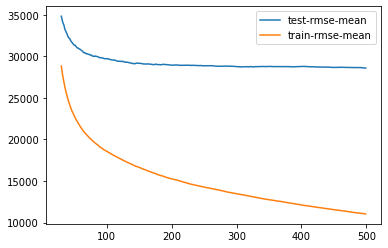

In [196]:
import xgboost as xgb
dtrain = xgb.DMatrix(X, label = y)
params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [198]:
# parameters tuned using xgb.cv
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=200, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X, y)
y_pred = model_xgb.predict(X_test)
print(y_pred)

[128910.984 158628.88  186365.31  ... 155390.02  119398.766 219571.2  ]


# Prediction with Test set

In [216]:
#for submission
df_submission = df_test.filter(['Id'],axis=1)
df_submission['SalePrice'] = pd.DataFrame(y_pred)
print(df_submission.head(5))
df_submission.to_csv("/Users/tahsin/Documents/kaggle/house_prices/submission.csv", index=False)

     Id      SalePrice
0  1461  126022.813514
1  1462  164366.624992
2  1463  174468.881202
3  1464  181526.395694
4  1465  202176.905505
